In [1]:
import numpy as np
import _pickle as pkl
import torch
import torch.nn as nn
%matplotlib inline 
import matplotlib.pyplot as plt
import os, sys, time
sys.path.append('../..')
from utils import set_seed_torch, rgb2gray, load_vh_models, frame_stack
set_seed_torch(3)
from train import encode
from argparse import Namespace
import json
import gzip
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

In [2]:
class ObjectView(object):
    def __init__(self, d): self.__dict__ = d

args = ObjectView({
 'res': 64,
 'dataset_path': ['/home/olimoyo/visual-haptic-dynamics/experiments/data/datasets/{}'
                   .format("vha1_2D_len16_oscxy_withGT_0B7AB071F98942578ABDA66879290F2F.pkl"),
                  '/home/olimoyo/visual-haptic-dynamics/experiments/data/datasets/{}'
                   .format("vha2_2D_len16_oscxy_withGT_3502DE81F7C343FB8B57FA92FDECF4DA.pkl"),
                  '/home/olimoyo/visual-haptic-dynamics/experiments/data/datasets/{}'
                   .format("vha3_2D_len16_oscxy_withGT_5DB32B21A6AA4E5892D2F6B8F40EF9E6.pkl")
                 ],
 'models_dir': '/home/olimoyo/visual-haptic-dynamics/saved_models/{}'
                   .format("vh"),
 'up_to_n_pred': 13,
#  'dataset_path': ['/home/olimoyo/visual-haptic-dynamics/experiments/data/datasets/mit_push/{}'
#                    .format("min-tr2.5_min-rot0.5_len48.pkl")
#                  ],
#  'models_dir': '/home/olimoyo/visual-haptic-dynamics/saved_models/{}'
#                    .format("mit"),
#  'up_to_n_pred': 42,
 'device': 'cuda:1',
 'n_initial': 2,
 'n_final': 2
})

def load_models_dir(models_dir):
    """Load hyperparameters from trained model."""
    dict_of_models = {}
    for filedir in os.listdir(models_dir):
        fullpath = os.path.join(models_dir, filedir)
        if os.path.isdir(fullpath):
            with open(os.path.join(fullpath, 'hyperparameters.txt'), 'r') as fp:
                dict_of_models[fullpath] = Namespace(**json.load(fp))
    return dict_of_models

def is_gz_file(filepath):
    with open(filepath, 'rb') as test_f:
        return test_f.read(2) == b'\x1f\x8b'
    
data = {
#     'img_rgb': [],
    'img_gray': [],
    'haptic': [],
    'arm': [],
    'actions': []
}

for dataset_path in args.dataset_path:
    if is_gz_file(dataset_path):
        with gzip.open(dataset_path, 'rb') as f:
            raw_data = pkl.load(f)
    else:
        with open(dataset_path, 'rb') as f:
            raw_data = pkl.load(f)

#     data['img_rgb'].append(torch.from_numpy(raw_data["img"].transpose(0, 1, 4, 2, 3)).int().to(device=args.device))
    data['img_gray'].append(torch.from_numpy(rgb2gray(raw_data["img"]).transpose(0, 1, 4, 2, 3)).float().to(device=args.device))
    data['haptic'].append(torch.from_numpy(raw_data['ft']).float().to(device=args.device))
    data['arm'].append(torch.from_numpy(raw_data['arm']).float().to(device=args.device))
    data['actions'].append(torch.from_numpy(raw_data["action"]).to(device=args.device).float())

data = {k:torch.cat(v, dim=0) for k,v in data.items()}

In [3]:
dict_of_models = load_models_dir(args.models_dir)
analysis_data = {}

with torch.no_grad():
    for path, model_args in dict_of_models.items():
        
        model_name = path.split("/")[-1]
        nets = load_vh_models(path=path, args=model_args, mode='eval', device=args.device)
        
        # Use validation indices only
        with open(os.path.join(path, "val_idx.pkl"), 'rb') as f:
            val_idx = pkl.load(f)
        data_val = {k:v[val_idx] for k,v in data.items()}
    
#         if model_args.dim_x[0] == 1:
#             imgs = data['img_gray']
#         elif model_args.dim_x[0] == 3:
#             imgs = data['img_rgb']
        img_key = 'img_gray'

        T = model_args.frame_stacks

        assert args.n_initial + args.up_to_n_pred <= data_val[img_key].shape[1]
        assert args.n_initial > T
        
        x_i = {}
        x_gt = {}
        
        analysis_data[model_name] = {}
        for n_pred in range(1, args.up_to_n_pred + 1):
            analysis_data[model_name][f"{n_pred}_pred"] = {
                "MSE_x": {"mu": 0, "std": 0},
                "MSE_z": {"mu": 0, "std": 0},
                "SSIM": {"mu": 0, "std": 0},
                "PSNR": {"mu": 0, "std": 0}
            }
            
            u = data_val['actions']

            # Sequence of initial images
            x_img_i = data_val[img_key][:, :args.n_initial] 
            x_img_i = frame_stack(x_img_i, frames=T)
            n, l = x_img_i.shape[0], x_img_i.shape[1] 
            x_i["img"] = x_img_i

            # Sequence of initial extra modalities
            x_ft_i = data_val['haptic'][:, :args.n_initial] / model_args.ft_normalization
            x_arm_i = data_val['arm'][:, :args.n_initial]               
            u_i = u[:, T:args.n_initial]

            if model_args.context_modality != "none":
                if model_args.context_modality == "joint":
                    x_i["context"] = torch.cat((x_ft_i, x_arm_i), dim=-1)
                elif model_args.context_modality == "ft":
                    x_i["context"] = x_ft_i
                elif model_args.context_modality == "arm":
                    x_i["context"] = x_arm_i

                if model_args.use_context_frame_stack:
                    x_i['context'] = frame_stack(x_i['context'], frames=T)
                else:
                    x_i["context"] = x_i["context"][:, T:]
                x_i["context"] = x_i["context"].transpose(-1, -2)
            x_i = {k:v.reshape(-1, *v.shape[2:]) for k, v in x_i.items()}

            # Sequence of gt images
            x_img_gt = data_val[img_key][:, (args.n_initial + n_pred - args.n_final):(args.n_initial + n_pred)]
            x_img_gt = frame_stack(x_img_gt, frames=T)
            l_gt = x_img_gt.shape[1]
            x_gt["img"] = x_img_gt
            
            # Sequence of gt extra modalities
            x_ft_gt = data_val['haptic'][:, (args.n_initial + n_pred - args.n_final):(args.n_initial + n_pred)] / model_args.ft_normalization
            x_arm_gt = data_val['arm'][:, (args.n_initial + n_pred - args.n_final):(args.n_initial + n_pred)]
            u_gt = u[:, (args.n_initial + n_pred - args.n_final + T):(args.n_initial + n_pred)]
            
            if model_args.context_modality != "none":
                if model_args.context_modality == "joint":
                    x_gt["context"] = torch.cat((x_ft_gt, x_arm_gt), dim=-1)
                elif model_args.context_modality == "ft":
                    x_gt["context"] = x_ft_gt
                elif model_args.context_modality == "arm":
                    x_gt["context"] = x_arm_gt

                if model_args.use_context_frame_stack:
                    x_gt['context'] = frame_stack(x_gt['context'], frames=T)
                else:
                    x_gt["context"] = x_gt["context"][:, T:]
                x_gt["context"] = x_gt["context"].transpose(-1, -2)
            x_gt = {k:v.reshape(-1, *v.shape[2:]) for k, v in x_gt.items()}

            # Encode
            if model_args.use_prior_expert:
                q_z_i, _, _ = encode(nets, model_args, x_i, u_i, device=args.device)
                q_z_gt, _, _ = encode(nets, model_args, x_gt, u_gt, device=args.device)
            else:
                q_z_i = encode(nets, model_args, x_i, u_i, device=args.device)
                q_z_gt = encode(nets, model_args, x_gt, u_gt, device=args.device)
            
            z_gt = q_z_gt["mu"]
            z_gt = z_gt.reshape(n, l_gt, -1)[:, -1]
            
            # Group and prepare for prediction
            q_z_i = {k:v.reshape(n, l, *v.shape[1:]).transpose(1,0) for k, v in q_z_i.items()}
            u = u.transpose(1,0)

            # First run
            z_i, mu_z_i, var_z_i = q_z_i["z"], q_z_i["mu"], q_z_i["cov"]
            u_i = u[(T + 1):(1 + args.n_initial)]
            h_i = None

            # Predict
            for jj in range(0, n_pred):
                z_ip1, mu_z_ip1, var_z_ip1, h_ip1 = nets["dyn"](
                    z_t=z_i, 
                    mu_t=mu_z_i, 
                    var_t=var_z_i, 
                    u=u_i, 
                    h_0=h_i, 
                    single=False
                )
                z_hat = mu_z_ip1[-1]
                z_i, mu_z_i, var_z_i, h_i = z_ip1[-1:], mu_z_ip1[-1:], var_z_ip1[-1:], h_ip1
                u_i = u[1 + args.n_initial + jj][None]
            
            # Decode 
            x_hat = nets["img_dec"](z_hat)
            x_hat = x_hat[:, 0].view(x_hat.shape[0], -1)
            x_img_gt = x_img_gt[:, -1, 0].view(x_img_gt.shape[0], -1)
            
            # Move to cpu, np
            x_hat = x_hat.cpu().numpy()
            z_hat = z_hat.cpu().numpy()
            x_img_gt = x_img_gt.cpu().numpy()
            z_gt = z_gt.cpu().numpy()
            
            batch_mse_img = np.sum(((x_img_gt - x_hat)**2), axis=-1)
            batch_mse_z = np.sum(((z_gt - z_hat)**2), axis=-1)
#             print("prediction length", n_pred, "starting position", T,
#                 "mean mse img: ", batch_mse_img.mean(),
#                 "std mse img: ", batch_mse_img.std(),
#                 "mean mse latent: ", batch_mse_z.mean(),
#                 "std mse latent: ", batch_mse_z.std())

            analysis_data[model_name][f"{n_pred}_pred"]["MSE_x"]["mu"] = batch_mse_img.mean()
            analysis_data[model_name][f"{n_pred}_pred"]["MSE_x"]["std"] = batch_mse_img.std()
            analysis_data[model_name][f"{n_pred}_pred"]["MSE_z"]["mu"] = batch_mse_z.mean()
            analysis_data[model_name][f"{n_pred}_pred"]["MSE_z"]["std"] = batch_mse_z.std()


            batch_ssim = []
            batch_psnr = []
            for jj in range(n):
                batch_ssim.append(ssim(
                    x_img_gt[jj].reshape(64,64), 
                    x_hat[jj].reshape(64,64), 
                    data_range=1.0
                ))
                batch_psnr.append(psnr(
                    x_img_gt[jj].reshape(64,64), 
                    x_hat[jj].reshape(64,64), 
                    data_range=1.0
                ))
            batch_ssim = np.array(batch_ssim)
            batch_psnr = np.array(batch_psnr)

            analysis_data[model_name][f"{n_pred}_pred"]["SSIM"]["mu"] = batch_ssim.mean()
            analysis_data[model_name][f"{n_pred}_pred"]["SSIM"]["std"] = batch_ssim.std()
            analysis_data[model_name][f"{n_pred}_pred"]["PSNR"]["mu"] = batch_psnr.mean()
            analysis_data[model_name][f"{n_pred}_pred"]["PSNR"]["std"] = batch_psnr.std()
    print("DONE!")

Loading models in path:  /home/olimoyo/visual-haptic-dynamics/saved_models/vh/1465883_nstep2_reproduce_1024optbase_noAnnealkl_yesWN_noBN_yeslearnuncertainty_notraininit_z16_net256_l0_lm_osc_vha_r1.00_kl1.00_lr3e4
Loading models in path:  /home/olimoyo/visual-haptic-dynamics/saved_models/vh/1485221_nstep2_1024optbase_noAnnealkl_yesWN_noBN_yeslearnuncertainty_notraininit_z16_net256_l0_lm_osc_va_r1.00_kl1.00_lr3e4
Loading models in path:  /home/olimoyo/visual-haptic-dynamics/saved_models/vh/1485220_nstep2_1024optbase_noAnnealkl_yesWN_noBN_yeslearnuncertainty_notraininit_z16_net256_l0_lm_osc_vh_r1.00_kl1.00_lr3e4
Loading models in path:  /home/olimoyo/visual-haptic-dynamics/saved_models/vh/1465882_nstep2_reproduce_1024optbase_noAnnealkl_yesWN_noBN_yeslearnuncertainty_notraininit_z16_net256_l0_lm_osc_v_r1.00_kl1.00_lr3e4
DONE!


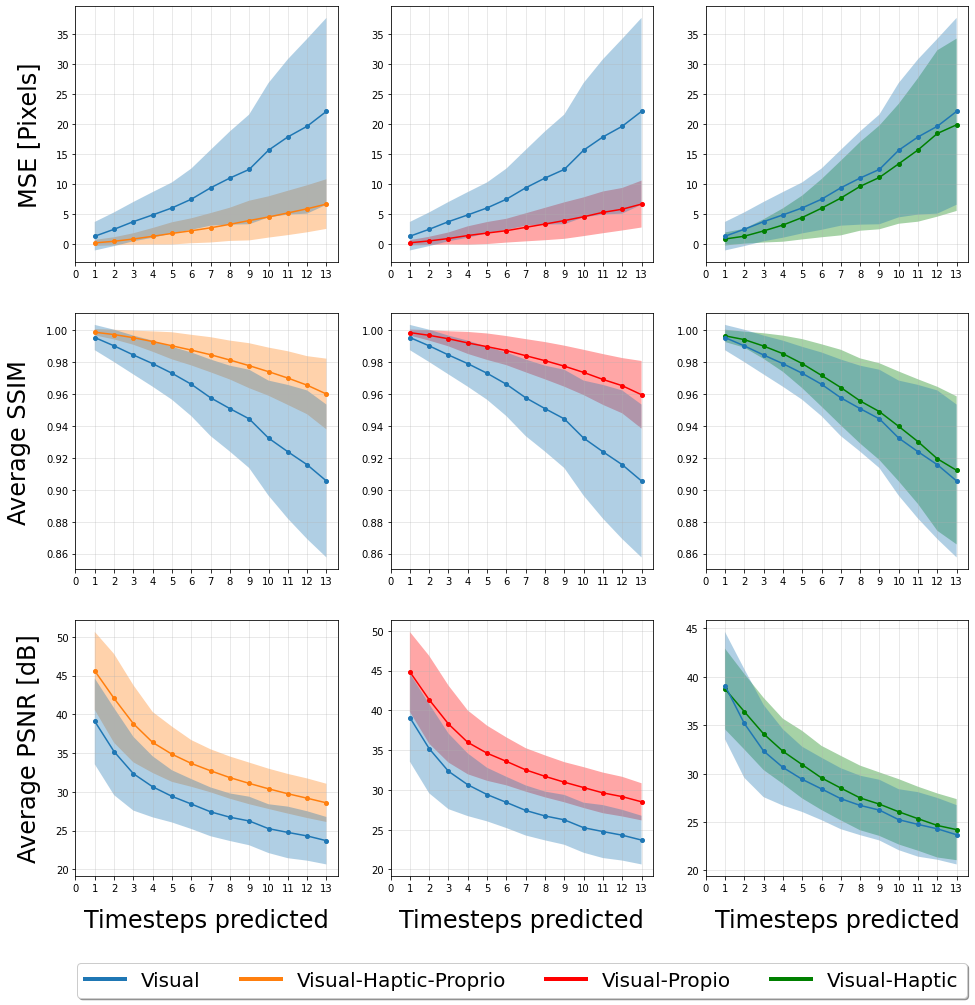

In [4]:
from matplotlib.lines import Line2D

def add_data_to_plot(name, data, var=True):
    
    if "_vha_" in name:
        color = '#ff7f0e'
        cols = [0]
    elif "_v_" in name:
        color = '#1f77b4'
        cols = [0, 1, 2]
    elif "_va_" in name:
        color = 'red'
        cols = [1]
    elif "_vh_" in name:
        color = 'green'
        cols = [2]
    
    if "_priorexpert-true" in name:
        marker = "x"
    else:
        marker = "o"
        
    if "mit" in args.dataset_path[0]:
        dt = 3
    else:
        dt = 1
    size = 4
    
    plot_data = {'MSE_x': {"mu":[], "std":[]}, 
                 'SSIM': {"mu":[], "std":[]}, 
                 'PSNR': {"mu":[], "std":[]}, 
                 "MSE_z": {"mu":[], "std":[]}}
    
    for k, v in data.items():
        plot_data['MSE_x']["mu"].append(v['MSE_x']["mu"])
        plot_data['MSE_x']["std"].append(v['MSE_x']["std"])
        plot_data['SSIM']["mu"].append(v['SSIM']["mu"])
        plot_data['SSIM']["std"].append(v['SSIM']["std"])
        plot_data['PSNR']["mu"].append(v['PSNR']["mu"])
        plot_data['PSNR']["std"].append(v['PSNR']["std"])
        plot_data['MSE_z']["mu"].append(v['MSE_z']["mu"])
        plot_data['MSE_z']["std"].append(v['MSE_z']["std"])

    custom_lines = [Line2D([0], [0], color='#1f77b4', lw=4),
                    Line2D([0], [0], color='#ff7f0e', lw=4),
                    Line2D([0], [0], color='red', lw=4),
                    Line2D([0], [0], color='green', lw=4)]

    axs[2,1].legend(
        custom_lines, 
        ['Visual',
         'Visual-Haptic-Proprio',
         'Visual-Propio',
         'Visual-Haptic'], 
        loc='upper center',
        bbox_to_anchor=(0.5, -0.30),
        fancybox=True,
        shadow=True,
        ncol=4,
        fontsize=20
    )
    
    for col in cols:
        axs[0,col].plot(
            list(range(1, len(plot_data['MSE_x']["mu"]) + 1)), 
            plot_data['MSE_x']["mu"],
            color=color, 
            marker=marker,
            markersize=size
        )
        if var:
            axs[0,col].fill_between(
                list(range(1, len(plot_data['MSE_x']["mu"]) + 1)), 
                [a_i + b_i for a_i, b_i in zip(plot_data['MSE_x']["mu"], plot_data['MSE_x']["std"])],
                [a_i - b_i for a_i, b_i in zip(plot_data['MSE_x']["mu"], plot_data['MSE_x']["std"])],
                facecolor=color, 
                alpha=0.35
            )

        axs[1,col].plot(
            list(range(1, len(plot_data['SSIM']["mu"]) + 1)), 
            plot_data['SSIM']["mu"],
            color=color, 
            marker=marker,
            markersize=size
        )
        if var:
            axs[1,col].fill_between(
                list(range(1, len(plot_data['SSIM']["mu"]) + 1)), 
                [a_i + b_i for a_i, b_i in zip(plot_data['SSIM']["mu"], plot_data['SSIM']["std"])],
                [a_i - b_i for a_i, b_i in zip(plot_data['SSIM']["mu"], plot_data['SSIM']["std"])],
                facecolor=color, 
                alpha=0.35
            )

        axs[2,col].plot(
            list(range(1, len(plot_data['PSNR']["mu"]) + 1)), 
            plot_data['PSNR']["mu"],
            color=color,
            marker=marker,
            markersize=size
        )
        if var:
            axs[2,col].fill_between(
                list(range(1, len(plot_data['PSNR']["mu"]) + 1)), 
                [a_i + b_i for a_i, b_i in zip(plot_data['PSNR']["mu"], plot_data['PSNR']["std"])],
                [a_i - b_i for a_i, b_i in zip(plot_data['PSNR']["mu"], plot_data['PSNR']["std"])],
                facecolor=color, 
                alpha=0.35
            )
        
#     axs[1,1].plot(
#         list(range(1, len(plot_data['MSE_z']["mu"]) + 1)), 
#         plot_data['MSE_z']["mu"],
#         color=color,
#         marker=marker
#     )
#     if var:
#         axs[1,1].fill_between(
#             list(range(1, len(plot_data['MSE_z']["mu"]) + 1)), 
#             [a_i + b_i for a_i, b_i in zip(plot_data['MSE_z']["mu"], plot_data['MSE_z']["std"])],
#             [a_i - b_i for a_i, b_i in zip(plot_data['MSE_z']["mu"], plot_data['MSE_z']["std"])],
#             facecolor=color, 
#             alpha=0.35
#         )
    
    for ii in range(axs.shape[0]):
        for jj in range(axs.shape[1]):
            axs[ii, jj].set_xticks(np.arange(0, args.up_to_n_pred + 1, dt))
            axs[ii, jj].grid(alpha=0.35, linestyle='solid', axis='both')

    for jj in range(axs.shape[1]):
        axs[2, jj].set_xlabel("Timesteps predicted", fontsize=24, labelpad=15)

    axs[0, 0].set_ylabel("MSE [Pixels]", fontsize=24, labelpad=15)
    axs[1, 0].set_ylabel("Average SSIM", fontsize=24, labelpad=15)
    axs[2, 0].set_ylabel("Average PSNR [dB]", fontsize=24, labelpad=15)
#     axs[1, 1].set_ylabel("MSE (Latent space)", fontsize=18)

fig, axs = plt.subplots(3, 3, figsize=(16,16))
for k, v in analysis_data.items():
    add_data_to_plot(k, v, var=True)

In [ ]:
#TODO: Calculate values for table